In [ ]:
# @title Instalação de bibliotecas

%%capture
!pip install moviepy
!pip install ultralytics
!pip install kaggle opendatasets

In [ ]:
# @title Importando bibliotecas

# Imports do sistema
import csv
import glob
import os

# Imports de terceiros
import cv2
from IPython.display import clear_output
import matplotlib.pyplot as plt
import moviepy.video.io.ImageSequenceClip
import numpy as np
import opendatasets as od
import pandas as pd
from PIL import Image
from pydantic import BaseModel
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm
import ultralytics
from ultralytics.engine.results import Results


In [ ]:
# @title Obter dataset

# Definição dos caminhos
PATH = '/content/drive/MyDrive/Materiais do TCC/Teste YOLO/Projeto Canoas/TCC2'
dataset_root = '/content/drive/MyDrive/Dataset_TCC/DATASET MELHORADO (DA)'

# Listagem das poses
pose_list = sorted(os.listdir(dataset_root))

# Exibição da lista de poses
pose_list


['Caido', 'Caminhando', 'Cansado', 'Mao_No_Peito', 'Mao_na_cabeca']

In [ ]:
# @title Remover arquivos que não seja PNG, JPG ou JPEG

# Loop através de cada pose
for pose in pose_list:
    diretorio = f'{dataset_root}/{pose}'

    # Lista os arquivos no diretório
    arquivos = os.listdir(diretorio)

    # Loop pelos arquivos
    for i, nome_arquivo in enumerate(arquivos):
        # Verifica se a extensão do arquivo não é .jpg, .png ou .jpeg
        _, extensao = os.path.splitext(nome_arquivo)

        # Checa se a extensão não é permitida
        if extensao.lower() not in ['.jpg', '.png', '.jpeg']:
            # Constrói o caminho completo para o arquivo
            caminho = os.path.join(diretorio, nome_arquivo)

            # Apaga arquivo indesejado
            os.remove(caminho)


In [ ]:
# @title Carregar o YOLOv8-pose

model = ultralytics.YOLO(model='yolov8x-pose-p6.pt')


100%|██████████| 190M/190M [00:05<00:00, 36.9MB/s]


In [ ]:
# @title Gerando o dataset

class GetKeypoint(BaseModel):
    """
    Modelo que define os keypoints do corpo humano e seus índices.
    """
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16


get_keypoint = GetKeypoint()


def extract_keypoint(keypoint):
    """
    Extrai as coordenadas dos keypoints de uma lista de keypoints.

    Args:
        keypoint (list): Lista de keypoints contendo as coordenadas.

    Returns:
        list: Uma lista contendo as coordenadas (x, y) dos keypoints.
    """
    keypoints = [
        'NOSE', 'LEFT_EYE', 'RIGHT_EYE', 'LEFT_EAR', 'RIGHT_EAR',
        'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW',
        'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_HIP', 'RIGHT_HIP',
        'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE'
    ]

    result = []
    for point in keypoints:
        x, y = keypoint[getattr(get_keypoint, point)]
        result.extend([x, y])

    return result


def process_image(image_path, pose):
    """
    Processa uma imagem para extrair keypoints de pose.

    Args:
        image_path (str): Caminho da imagem a ser processada.
        pose (str): A pose associada à imagem.

    Returns:
        list: Lista de tuplas contendo o nome da imagem, a pose e as coordenadas dos keypoints.
    """
    try:
        # Extrai o nome da imagem do caminho
        image_name = os.path.basename(image_path)

        # Lê a imagem usando o OpenCV
        image = cv2.imread(image_path)

        # Executa a detecção de pessoas
        results = model.predict(image, save=False, conf=0.50)[0]

        # Obtém keypoints e coordenadas das bounding boxes
        keypoints = results.keypoints.xyn.cpu().numpy()

        # Verifica se há apenas uma pessoa detectada
        if len(results.boxes.xyxy) == 1:
            # Filtra keypoints com 17 elementos
            return [(image_name, pose, *extract_keypoint(keypoint)) for keypoint in keypoints if len(keypoint) == 17]

        return []
    except IndexError:
        return []


dataset_csv = []
for pose in pose_list:
    # Obtém todos os caminhos das imagens para a pose atual
    image_paths = glob.glob(f'{dataset_root}/{pose}/*.*')
    for image_path in image_paths:
        dataset_csv.extend(process_image(image_path, pose))

# Define partes do corpo e suas coordenadas
body_parts = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
              'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
              'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
              'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
              ]

# Gera o cabeçalho usando compreensão de lista
header = ['image_name', 'label'] + [f'{part}_{coord}' for part in body_parts for coord in ['x', 'y']]

# Define o caminho do arquivo
file_path = os.path.join(PATH, 'keypoints_pose_v1.csv')

# Escreve no CSV
with open(file_path, 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)  # Escreve o cabeçalho
    writer.writerows(dataset_csv)  # Escreve várias linhas


A saída de streaming foi truncada nas últimas 5000 linhas.
0: 832x1280 1 person, 156.5ms
Speed: 6.7ms preprocess, 156.5ms inference, 1.4ms postprocess per image at shape (1, 3, 832, 1280)

0: 896x1280 1 person, 162.2ms
Speed: 9.7ms preprocess, 162.2ms inference, 2.5ms postprocess per image at shape (1, 3, 896, 1280)

0: 896x1280 1 person, 158.1ms
Speed: 7.6ms preprocess, 158.1ms inference, 1.5ms postprocess per image at shape (1, 3, 896, 1280)

0: 768x1280 1 person, 136.8ms
Speed: 3.7ms preprocess, 136.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1280)

0: 896x1280 1 person, 160.0ms
Speed: 7.2ms preprocess, 160.0ms inference, 1.4ms postprocess per image at shape (1, 3, 896, 1280)

0: 896x1280 1 person, 161.1ms
Speed: 7.1ms preprocess, 161.1ms inference, 1.8ms postprocess per image at shape (1, 3, 896, 1280)

0: 960x1280 1 person, 173.4ms
Speed: 7.7ms preprocess, 173.4ms inference, 1.6ms postprocess per image at shape (1, 3, 960, 1280)

0: 896x1280 1 person, 161.6ms
S

In [ ]:
# @title Escrevendo as alterações no arquivo

# Carrega o DataFrame a partir do arquivo CSV
df = pd.read_csv(PATH + '/keypoints_pose_v1.csv')

# Remove a coluna 'image_name'
df = df.drop('image_name', axis=1)

# Exibe as 5 primeiras linhas do DataFrame
df.head()


,label,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,coord_box_min_x,coord_box_min_y,coord_box_max_x,coord_box_max_y
0,Caido,0.792430,0.613291,0.799647,0.631989,0.800377,0.603245,0.778640,0.693841,0.787107,...,0.559041,0.439603,0.512550,0.241521,0.528212,0.228444,928.0,64.0,1633.0,842.0
1,Caido,0.625301,0.288902,0.662422,0.235695,0.596074,0.234829,0.706336,0.238714,0.555535,...,0.871672,0.195308,0.967513,0.120665,0.907647,0.081932,195.0,4.0,640.0,295.0
2,Caido,0.372103,0.386051,0.373427,0.341881,0.348586,0.367384,0.378351,0.311462,0.305991,...,0.511068,0.862256,0.892082,0.604929,0.735559,0.828270,296.0,154.0,1251.0,668.0
3,Caido,0.156863,0.411583,0.154728,0.384514,0.141616,0.407594,0.160759,0.347576,0.126216,...,0.314429,0.535502,0.448568,0.583480,0.391605,0.595416,3.0,106.0,295.0,242.0
4,Caido,0.669781,0.656873,0.677087,0.678207,0.685352,0.637484,0.000000,0.000000,0.688933,...,0.385452,0.668150,0.309221,0.786041,0.200879,0.686373,129.0,269.0,1013.0,705.0


In [ ]:
# @title Verificando os tipos dos dados

# Exibe informações sobre o DataFrame, como tipos de dados e valores nulos
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4399 entries, 0 to 4398
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   label             4399 non-null   object 
 1   nose_x            4399 non-null   float64
 2   nose_y            4399 non-null   float64
 3   left_eye_x        4399 non-null   float64
 4   left_eye_y        4399 non-null   float64
 5   right_eye_x       4399 non-null   float64
 6   right_eye_y       4399 non-null   float64
 7   left_ear_x        4399 non-null   float64
 8   left_ear_y        4399 non-null   float64
 9   right_ear_x       4399 non-null   float64
 10  right_ear_y       4399 non-null   float64
 11  left_shoulder_x   4399 non-null   float64
 12  left_shoulder_y   4399 non-null   float64
 13  right_shoulder_x  4399 non-null   float64
 14  right_shoulder_y  4399 non-null   float64
 15  left_elbow_x      4399 non-null   float64
 16  left_elbow_y      4399 non-null   float64


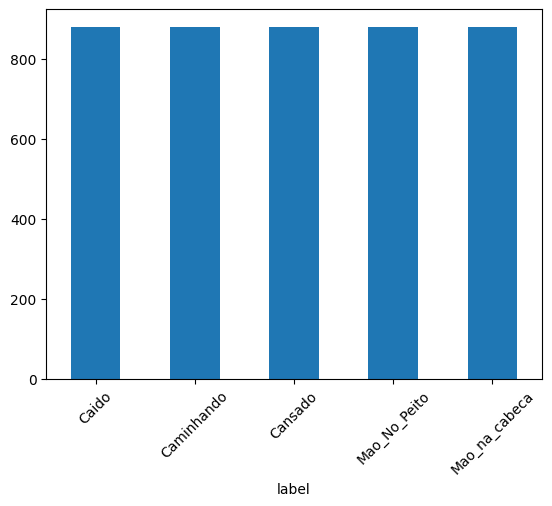

In [ ]:
# @title Exibindo as instâncias coletadas para cada classe

# Conta os valores da coluna 'label' e plota um gráfico de barras
df.label.value_counts().plot(kind="bar")

# Rotaciona os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Exibe o gráfico
plt.show()
